| Method    | Description | SQL equivalents |
| -------- | ------- | ------- |
|`Join` |Applies a lookup strategy to match elements from two collections,<br>emitting a flat result set |INNER JOIN
|`GroupJoin` |Similar to Join, but emits a hierarchical result set |INNER JOIN,<br>LEFT OUTER JOIN
|`Zip` |Enumerates two sequences in step (like a zipper), applying a function<br>over each element pair |Exception thrown

### Join and GroupJoin

`IEnumerable<TOuter>`, `IEnumerable<TInner>`→`IEnumerable<TResult>`

***Join arguments***

| Argument    | Type |
| -------- | ------- |
|`Outer sequence` |`IEnumerable<TOuter>`
|`Inner sequence` |`IEnumerable<TInner>`
|`Outer key selector` |`TOuter` => `TKey`
|`Inner key selector` |TInner => TKey
|`Result selector` | (TOuter,TInner) => TResult


***GroupJoin arguments***

| Argument    | Type |
| -------- | ------- |
|`Outer sequence` |`IEnumerable<TOuter>`
|`Inner sequence` |`IEnumerable<TInner>`
|`Outer key selector` |`TOuter` => `TKey`
|`Inner key selector` |TInner => TKey
|`Result selector` | (TOuter,IEnumerable<TInner>) => TResult

***Query syntax***  

`from` **outer-var** `in` ***outer-enumerable***  
`join` **inner-var** `in` ***inner-enumerable*** `on` **outer-key-expr** `equals` **inner-key-expr**  
`[ into identifier ]`

***Join*** and ***GroupJoin*** mesh(دوختن) `two` input `sequences` into a `single` output sequence. ***Join*** emits(منتشر می کند) `flat output`; ***GroupJoin*** emits `hierarchical output`.

<div dir="rtl" style="width:90%; margin:auto">

<p><strong>Join</strong>: این تابع یک جوین داخلی (inner join) بین دو کلکسیون انجام می‌دهد. به این صورت که هر عنصر از کلکسیون اول که با یک عنصر از کلکسیون دوم مطابقت دارد، ترکیب شده و در نتیجه نمایش داده می‌شود.</p>

<p><strong>GroupJoin</strong>: این تابع جوین خارجی (left outer join) را بین دو کلکسیون انجام می‌دهد. عناصر از کلکسیون اول همراه با کلکسیون‌هایی از عناصر مطابق در کلکسیون دوم نمایش داده می‌شوند، و اگر مطابقتی وجود نداشته باشد، کلکسیون دوم خالی خواهد بود.</p>


<p>این توابع مزیت کارایی بالایی در کار با کلکسیون‌های حافظه‌ای (in-memory) دارند، زیرا:</p>
<ul><li>آنها داده‌های کلکسیون داخلی (inner collection) را در یک ساختار داده‌ای کلیدی بارگذاری می‌کنند که جستجو و دسترسی به عناصر را تسریع می‌بخشد.</li><li>این کار از تکرار مکرر بر روی هر عنصر داخلی جلوگیری می‌کند، که به کارایی بهتری منجر می‌شود.</li></ul>

<h3>معایب <code>Join</code> و <code>GroupJoin</code></h3>
<ul><li>این توابع تنها جوین‌های داخلی و خارجی سمت چپ را پشتیبانی می‌کنند.</li><li>برای انجام حاصل ضرب دکارتی (cross join) یا جوین‌های غیر تساوی (non-equi join)، باید از توابع <code>Select</code> یا <code>SelectMany</code> استفاده شود.</li></ul>

</div>

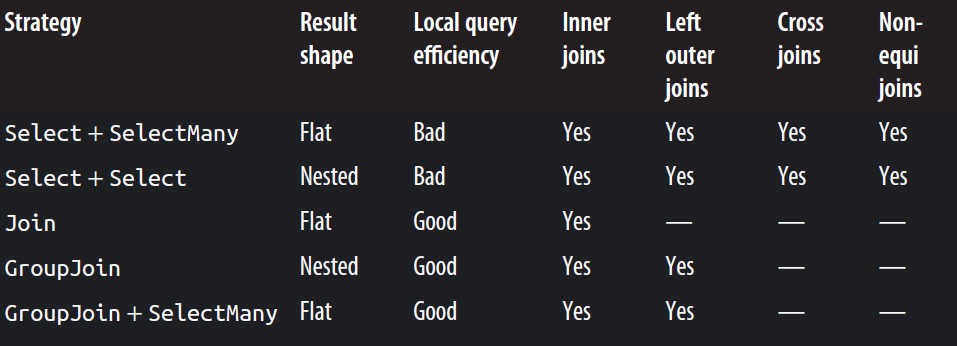

### Join

In [ ]:
IQueryable<string> query =
    from c in dbContext.Customers
    join p in dbContext.Purchases on c.ID equals p.CustomerID
    select c.Name + " bought a " + p.Description;

In [ ]:
//To see the benefit of Join over SelectMany, we must convert this to a local query.

Customer[] customers = dbContext.Customers.ToArray();
Purchase[] purchases = dbContext.Purchases.ToArray();

var slowQuery = from c in customers
                from p in purchases where c.ID == p.CustomerID
                select c.Name + " bought a " + p.Description;

var fastQuery = from c in customers
                join p in purchases on c.ID equals p.CustomerID
                select c.Name + " bought a " + p.Description;

//faster because its implementation in Enumerable preloads the inner collection
//(purchases) into a keyed lookup.

***Join*** operators in LINQ differentiate between the `outer sequence` and `inner sequence`.  

- The ***outer sequence*** is the `input sequence` (`customers`, in this case).
- The ***inner sequence*** is the `new collection` you introduce (`purchases`, in this
case).

In [ ]:
//because join is inner join you can change position of outer and inner sequence

IQueryable<string> query =
    from p in dbContext.Purchases 
    join c in dbContext.Customers on p.ID equals c.CustomerID
    select c.Name + " bought a " + p.Description;

### Joining on multiple keys

In [ ]:
IQueryable<string> query =
    from p in dbContext.Purchases 
    join c in dbContext.Customers on new{ p.ID, p.TestId} 
                            equals new{ c.CustomerID, c.TestId}
    select c.Name + " bought a " + p.Description;

#### Joining in fluent syntax

In [ ]:
IQueryable<string> query =
    from c in dbContext.Customers
    join p in dbContext.Purchases on c.ID equals p.CustomerID
    select new{c.Name , p.Description, p.Price} ;

//fluent syntax

dbContext.Customers.Join(    //outer collection
    dbContext.Purchases,     //inner collection
    c => c.ID,               //outer key selector
    p => p.CustomerID,       //inner key selector
    (c, p) => new {c.Name , p.Description, p.Price} //result selector
)


### GroupJoin

***GroupJoin*** does the same work as `Join`, but instead of yielding a flat result, it `yields` a `hierarchical result`, `grouped by` each `outer element`.

The query syntax for ***GroupJoin*** is the same as for `Join`, but is followed by the `into` keyword.

In [ ]:
Customer[] customers = dbContext.Customers.ToArray();
Purchase[] purchases = dbContext.Purchases.ToArray();

IEnumerable<IEnumerable<Purchase>> query =
from c in customers
join p in purchases on c.ID equals p.CustomerID
into custPurchases
select new { CustName = c.Name, custPurchases }; // custPurchases is a sequence


In [ ]:
//by default GroupJoin is left outer join, for achive inner join 

Customer[] customers = dbContext.Customers.ToArray();
Purchase[] purchases = dbContext.Purchases.ToArray();

IEnumerable<IEnumerable<Purchase>> query =
from c in customers
join p in purchases on c.ID equals p.CustomerID
into custPurchases
where custPurchases.Any()    // inner join
select new { CustName = c.Name, custPurchases }; // custPurchases is a sequence

### Flat outer joins

In [ ]:
Customer[] customers = dbContext.Customers.ToArray();
Purchase[] purchases = dbContext.Purchases.ToArray();


IEnumerable<IEnumerable<Purchase>> query =
from c in customers
join p in purchases on c.ID equals p.CustomerID into custPurchases
from cp in custPurchases.DefaultIfEmpty() //select many and null for person dont have purchases
select new
{
    CustName = c.Name,
    Price = cp == null ? (decimal?) null : cp.Price
};


### Joining with lookups

ما قبلا گفتیم که در حالتی که ما از کوئری های لوکال استفاده میکنم   
  

***Join*** and ***GroupJoin*** are `faster` than ***select*** and ***selectmany***  
  
beacuse its implementation in `Enumerable` preloads the `inner collection` (purchases) into a `keyed lookup`

<div dir="rtl" style="width:80%; margin:auto">
"lookup" به ساختار داده‌ای اشاره دارد که در آن، داده‌ها برای دسترسی سریع و جستجوی کارآمد ذخیره می‌شوند. به عنوان یک نوع خاص از دیکشنری عمل می‌کند که مقادیر چندتایی (multi-values) را برای هر کلید می‌تواند نگهداری کند.
<h3>چرا Lookup استفاده می‌شود؟</h3>
<p><strong>سرعت دسترسی</strong>: Lookup بهینه‌سازی شده است برای جستجوهای سریع، که برای عملیات‌هایی مانند پیوستن داده‌ها که نیاز به مقایسه مقادیر کلیدها بین دو مجموعه دارد، مفید است.</p>
<p><strong>سازماندهی داده‌ها</strong>: وقتی داده‌ها در یک lookup ذخیره می‌شوند، دسترسی به داده‌های مرتبط با هر کلید ساده‌تر و سریع‌تر می‌شود، زیرا همه داده‌های مرتبط با یک کلید خاص در یک محل نگهداری می‌شوند.</p>

<h3>کاربرد در <code>Join</code> و <code>GroupJoin</code></h3>
<p>در متدهای <code>Join</code> و <code>GroupJoin</code>، فرآیند به این صورت است:</p>
<ol><li><p><strong>بارگذاری داده‌ها به lookup</strong>: در ابتدا، داده‌ها از دنباله داخلی (inner sequence) به lookup بارگذاری می‌شوند. این به این معنی است که داده‌های دنباله داخلی (مثلاً <code>purchases</code> در مثالی که قبلاً بررسی کردیم) بر اساس کلیدهایی که برای پیوستن استفاده می‌شود (مثلاً <code>CustomerID</code>)، در lookup ذخیره می‌شوند.</p></li><li><p><strong>پرس‌وجوی دنباله خارجی با استفاده از lookup</strong>: سپس، برای هر عنصر در دنباله خارجی (outer sequence)، مثلاً <code>customers</code>، lookup برای یافتن داده‌های مرتبط بر اساس کلید مرتبط (در این مورد <code>ID</code> مشتری) جستجو می‌شود. این عمل اجازه می‌دهد که برای هر مشتری، خریدهای مرتبط به دست آید و به نتیجه نهایی پیوست داده شود.</p></li></ol>
</div>

In [ ]:
ILookup<int,List<Purchese>> purchLookup = 
    dbContext.Persons
    .Include(p => p.Purcheses)
    .ToList()
    .ToLookup(p => p.Id, p=>p.Purcheses);

    foreach (Purchase p in purchLookup [1]) //the indexer returns a sequence of 
                                            //matching items rather than a single matching item
        Console.WriteLine (p.Description);

In [ ]:
public static IEnumerable <TResult> Join <TOuter,TInner,TKey,TResult> (
    this IEnumerable <TOuter> outer,
    IEnumerable <TInner> inner,
    Func <TOuter,TKey> outerKeySelector,
    Func <TInner,TKey> innerKeySelector,
    Func <TOuter,TInner,TResult> resultSelector)
{
    ILookup <TKey, TInner> lookup = inner.ToLookup (innerKeySelector);
    return
        from outerItem in outer
        from innerItem in lookup [outerKeySelector (outerItem)]
        select resultSelector (outerItem, innerItem);
}


public static IEnumerable <TResult> GroupJoin <TOuter,TInner,TKey,TResult> (
    this IEnumerable <TOuter> outer,
    IEnumerable <TInner> inner,
    Func <TOuter,TKey> outerKeySelector,
    Func <TInner,TKey> innerKeySelector,
    Func <TOuter,IEnumerable<TInner>,TResult> resultSelector)
{
    ILookup <TKey, TInner> lookup = inner.ToLookup (innerKeySelector);
    return
        from outerItem in outer
        select resultSelector
        (outerItem, lookup [outerKeySelector (outerItem)]);
}

### The Zip Operator

`IEnumerable<TFirst>`, `IEnumerable<TSecond>`→`IEnumerable<TResult>`

The ***Zip*** operator `enumerates` two **sequences** in `step` (like a zipper), returning a `sequence` based on applying `a function` over `each element pair`.

In [1]:
int[] numbers = { 3, 5, 7 };
string[] words = { "three", "five", "seven", "ignored" };
IEnumerable<string> zip = numbers.Zip (words, (n, w) => n + "=" + w);

foreach(string s in zip)
    Console.WriteLine(s);
/*
3=three
5=five
7=seven
*/

3=three
5=five
7=seven
